In [84]:
import numpy as np
import timeautoencoder as tae
import timediffusion as tdf
import DP as dp
import pandas as pd
import torch
import os
import time
import process_edited as pce

In [89]:
# original below 
# edits:
# epochs
# .astype(np.float32) for data conistency (no information loss?) 
    # next box they use torch.tensor(data.astype('float32')).numpy() to convert to tensor
#  


data = 'Sine'
filename = f'C:/Nextcloud/Uni/Uni LE/Masterarbeit/MACode/model 1/Dataset/Single-Sequence/sinecurve_with_date_new.csv'

# Read the DataFrame
real_df = pd.read_csv(filename)

# Pre-process DataFrames
real_df1 = real_df.drop('date', axis=1).iloc[0:2000, :]
real_df2 = real_df.iloc[0:2000, :]

# Pre-processing Data
threshold = 1
device = 'cpu'
column_to_partition = 'Symbol'

# Data pre-processing
processed_data = dp.splitData(real_df1, 24, threshold)
time_info = dp.splitTimeData(real_df2, processed_data.shape[1]).to(device)

##############################################################################################################################
# Auto-encoder Training
n_epochs = 5000 # 50000 original setting
eps = 1e-5
weight_decay = 1e-6
lr = 2e-4
hidden_size = 200
num_layers = 1
batch_size = 50 #50 original
channels = 64
min_beta = 1e-5
max_beta = 0.1
emb_dim = 128
time_dim = 8
lat_dim = 7

# Training autoencoder
ds = tae.train_autoencoder(real_df1, processed_data, channels, hidden_size, num_layers, lr, weight_decay, n_epochs,
                           batch_size, threshold, min_beta, max_beta, emb_dim, time_dim, lat_dim, device)

##############################################################################################################################
# Diffusion Training
latent_features = ds[1].to(device='cpu', dtype=torch.float32)
time = time_info.to(device='cpu', dtype=torch.float32)

hidden_dim = 200
num_layers = 2
diffusion_steps = 100
n_epochs = 5000
num_classes = len(latent_features)

# Training diffusion model
diff = tdf.train_diffusion(latent_features, time, hidden_dim, num_layers, diffusion_steps, n_epochs)

##############################################################################################################################
# Sampling new data
latent_features = latent_features.to(dtype=torch.float32)
T = latent_features.shape[1]
N, _, _ = latent_features.shape # this makes sure that not more samples are generated than the original data

t_grid = torch.linspace(0, 1, T).view(1, -1, 1).to('cpu', dtype=torch.float32)
samples = tdf.sample(t_grid.repeat(N, 1, 1), latent_features.detach().to('cpu'), diff, time)

##############################################################################################################################
'''latent_features = latent_features.to(dtype=torch.float32)
T = latent_features.shape[1]
N = 300  # Desired number of samples

available_N = latent_features.shape[0]
# Use torch.multinomial to sample with replacement
indices = torch.multinomial(torch.ones(available_N), N, replacement=True)
sampled_latent_features = latent_features[indices]  # Sample with replacement

t_grid = torch.linspace(0, 1, T).view(1, -1, 1).to('cpu', dtype=torch.float32)
samples = tdf.sample(t_grid.repeat(N, 1, 1), sampled_latent_features.detach().to('cpu'), diff, time)'''


##############################################################################################################################
# Post-process the generated data 
gen_output = ds[0].decoder(samples.to('cpu'))

# Convert to synthetic data
data_size, seq_len, _ = latent_features.shape
synth_data = pce.convert_to_tensor(real_df1, gen_output, threshold, data_size, seq_len)
_synth_data = pce.convert_to_table(real_df1, synth_data, threshold)

##############################################################################################################################
# Draw the plots for marginal of features : Real vs. Synthetic
_real_data = pce.convert_to_table(real_df1, processed_data, threshold)

# Reshape data for comparison
B, L, K = _synth_data.shape
sd_reshaped = _synth_data.reshape(B * L, K).to('cpu', dtype=torch.float32)
pd_reshaped = _real_data.reshape(B * L, K).to('cpu', dtype=torch.float32)

# Convert reshaped tensors to DataFrames
real_df = pd.DataFrame(pd_reshaped.numpy())
synth_df = pd.DataFrame(sd_reshaped.numpy())


Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [90]:
import numpy
parser = pce.DataFrameParser().fit(real_df1, threshold)
data = parser.transform()
torch.tensor(data.astype('float32')).numpy()

array([[4.99999970e-01],
       [5.10506332e-01],
       [5.21008074e-01],
       [5.31500518e-01],
       [5.41979074e-01],
       [5.52439094e-01],
       [5.62875926e-01],
       [5.73285043e-01],
       [5.83661735e-01],
       [5.94001532e-01],
       [6.04299784e-01],
       [6.14552021e-01],
       [6.24753654e-01],
       [6.34900212e-01],
       [6.44987226e-01],
       [6.55010164e-01],
       [6.64964676e-01],
       [6.74846351e-01],
       [6.84650779e-01],
       [6.94373727e-01],
       [7.04010785e-01],
       [7.13557839e-01],
       [7.23010540e-01],
       [7.32364774e-01],
       [7.41616368e-01],
       [7.50761330e-01],
       [7.59795547e-01],
       [7.68715024e-01],
       [7.77515829e-01],
       [7.86194146e-01],
       [7.94746041e-01],
       [8.03167820e-01],
       [8.11455667e-01],
       [8.19606066e-01],
       [8.27615261e-01],
       [8.35479856e-01],
       [8.43196273e-01],
       [8.50761175e-01],
       [8.58171165e-01],
       [8.65422964e-01],


In [91]:
data.shape

(600, 1)

In [ ]:
#if presaved data available

data = 'AirQuality'
filename = f'Data/{data}.csv'

# Read dataframe
print(filename)
real_df = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1).iloc[0:2000,:]

_synth_data = torch.load(f'Data/AirQuality_synth.pt')
_real_data = torch.load(f'Data/AirQuality_real.pt')

B, L, K = _real_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)


IndexError: index 1 is out of bounds for dimension 1 with size 1

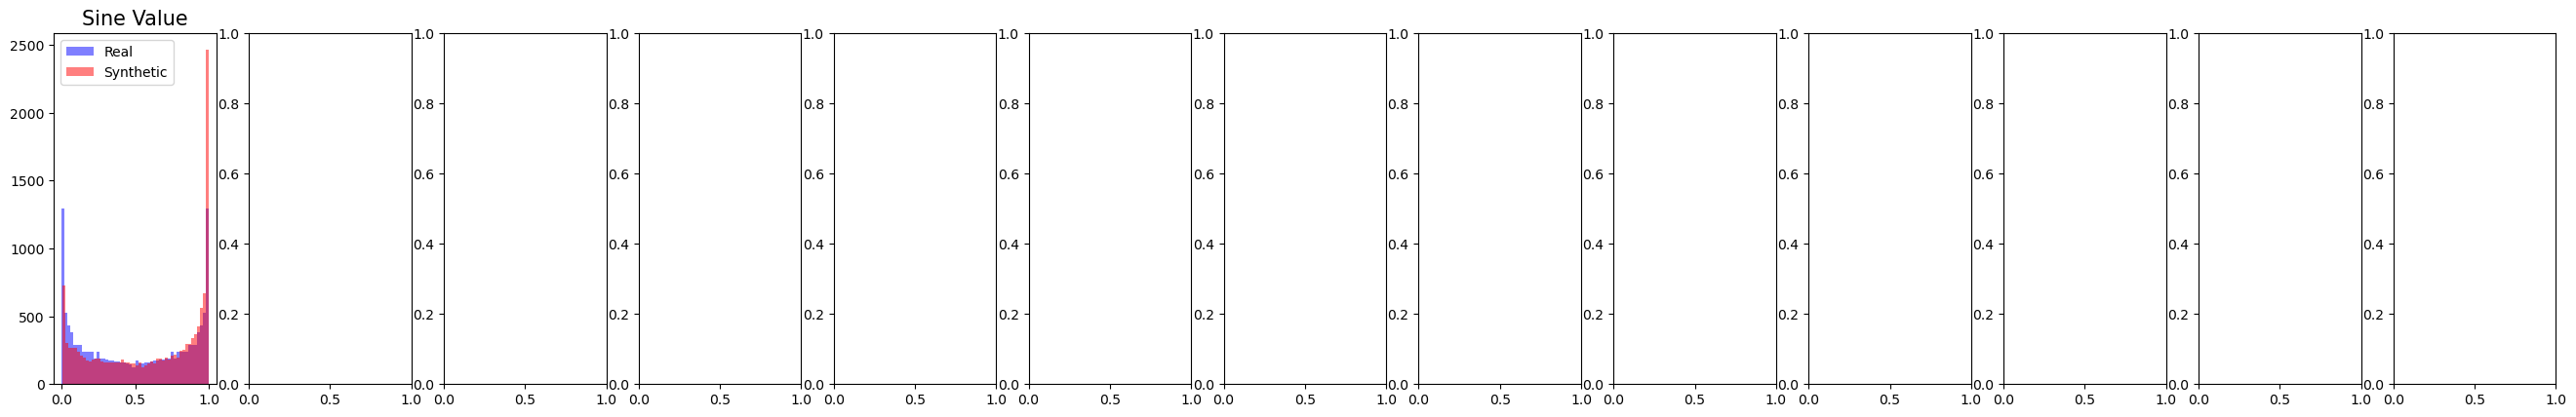

In [92]:
parser = pce.DataFrameParser().fit(real_df1, threshold)
col_name = parser.column_name()

import matplotlib.pyplot as plt
import torch
import numpy as np

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=13, figsize=(33.1, 23.4/5))

for k in range(13):
    axes[k].hist(pd_reshaped[:, k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:, k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')

    # Adding legends
    axes[k].legend()
    axes[k].set_title(col_name[k], fontsize=15)
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between histograms
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality
plt.show()

In [22]:
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
import torch

# Check the shapes of the tensors
print(f"pd_reshaped shape: {pd_reshaped.shape}")
print(f"sd_reshaped shape: {sd_reshaped.shape}")

# Adjust indexing based on actual tensor dimensions
if pd_reshaped.dim() == 3:
    X1_real = pd_reshaped[:, :, 0].flatten()  # Assuming X1 is the first feature
    X2_real = pd_reshaped[:, :, 1].flatten()  # Assuming X2 is the second feature

    X1_synth = sd_reshaped[:, :, 0].flatten()  # Assuming X1 is the first feature
    X2_synth = sd_reshaped[:, :, 1].flatten()  # Assuming X2 is the second feature

elif pd_reshaped.dim() == 2:
    X1_real = pd_reshaped[:, 0].flatten()  # Adjust for 2D: first column as X1
    X2_real = pd_reshaped[:, 1].flatten()  # Adjust for 2D: second column as X2

    X1_synth = sd_reshaped[:, 0].flatten()  # Adjust for 2D: first column as X1
    X2_synth = sd_reshaped[:, 1].flatten()  # Adjust for 2D: second column as X2

else:
    raise ValueError("Unexpected tensor dimensions. Expected 2D or 3D tensors.")

# Print the first few data points to check their range
print("First few values of X1_real:", X1_real[:10])
print("First few values of X2_real:", X2_real[:10])
print("First few values of X1_synth:", X1_synth[:10])
print("First few values of X2_synth:", X2_synth[:10])

# Create subplots for real and synthetic data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))  # Two rows: one for each dataset

# Plot real data
axes[0].plot(X1_real, X2_real, color='blue', label='Real Data')
axes[0].set_title('Real Data: X1 vs. X2')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
axes[0].legend()

# Plot synthetic data
axes[1].plot(X1_synth, X2_synth, color='red', linestyle='--', label='Synthetic Data')
axes[1].set_title('Synthetic Data: X1 vs. X2')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between the two plots
plt.show()


pd_reshaped shape: torch.Size([6624, 1])
sd_reshaped shape: torch.Size([6624, 1])


IndexError: index 1 is out of bounds for dimension 1 with size 1

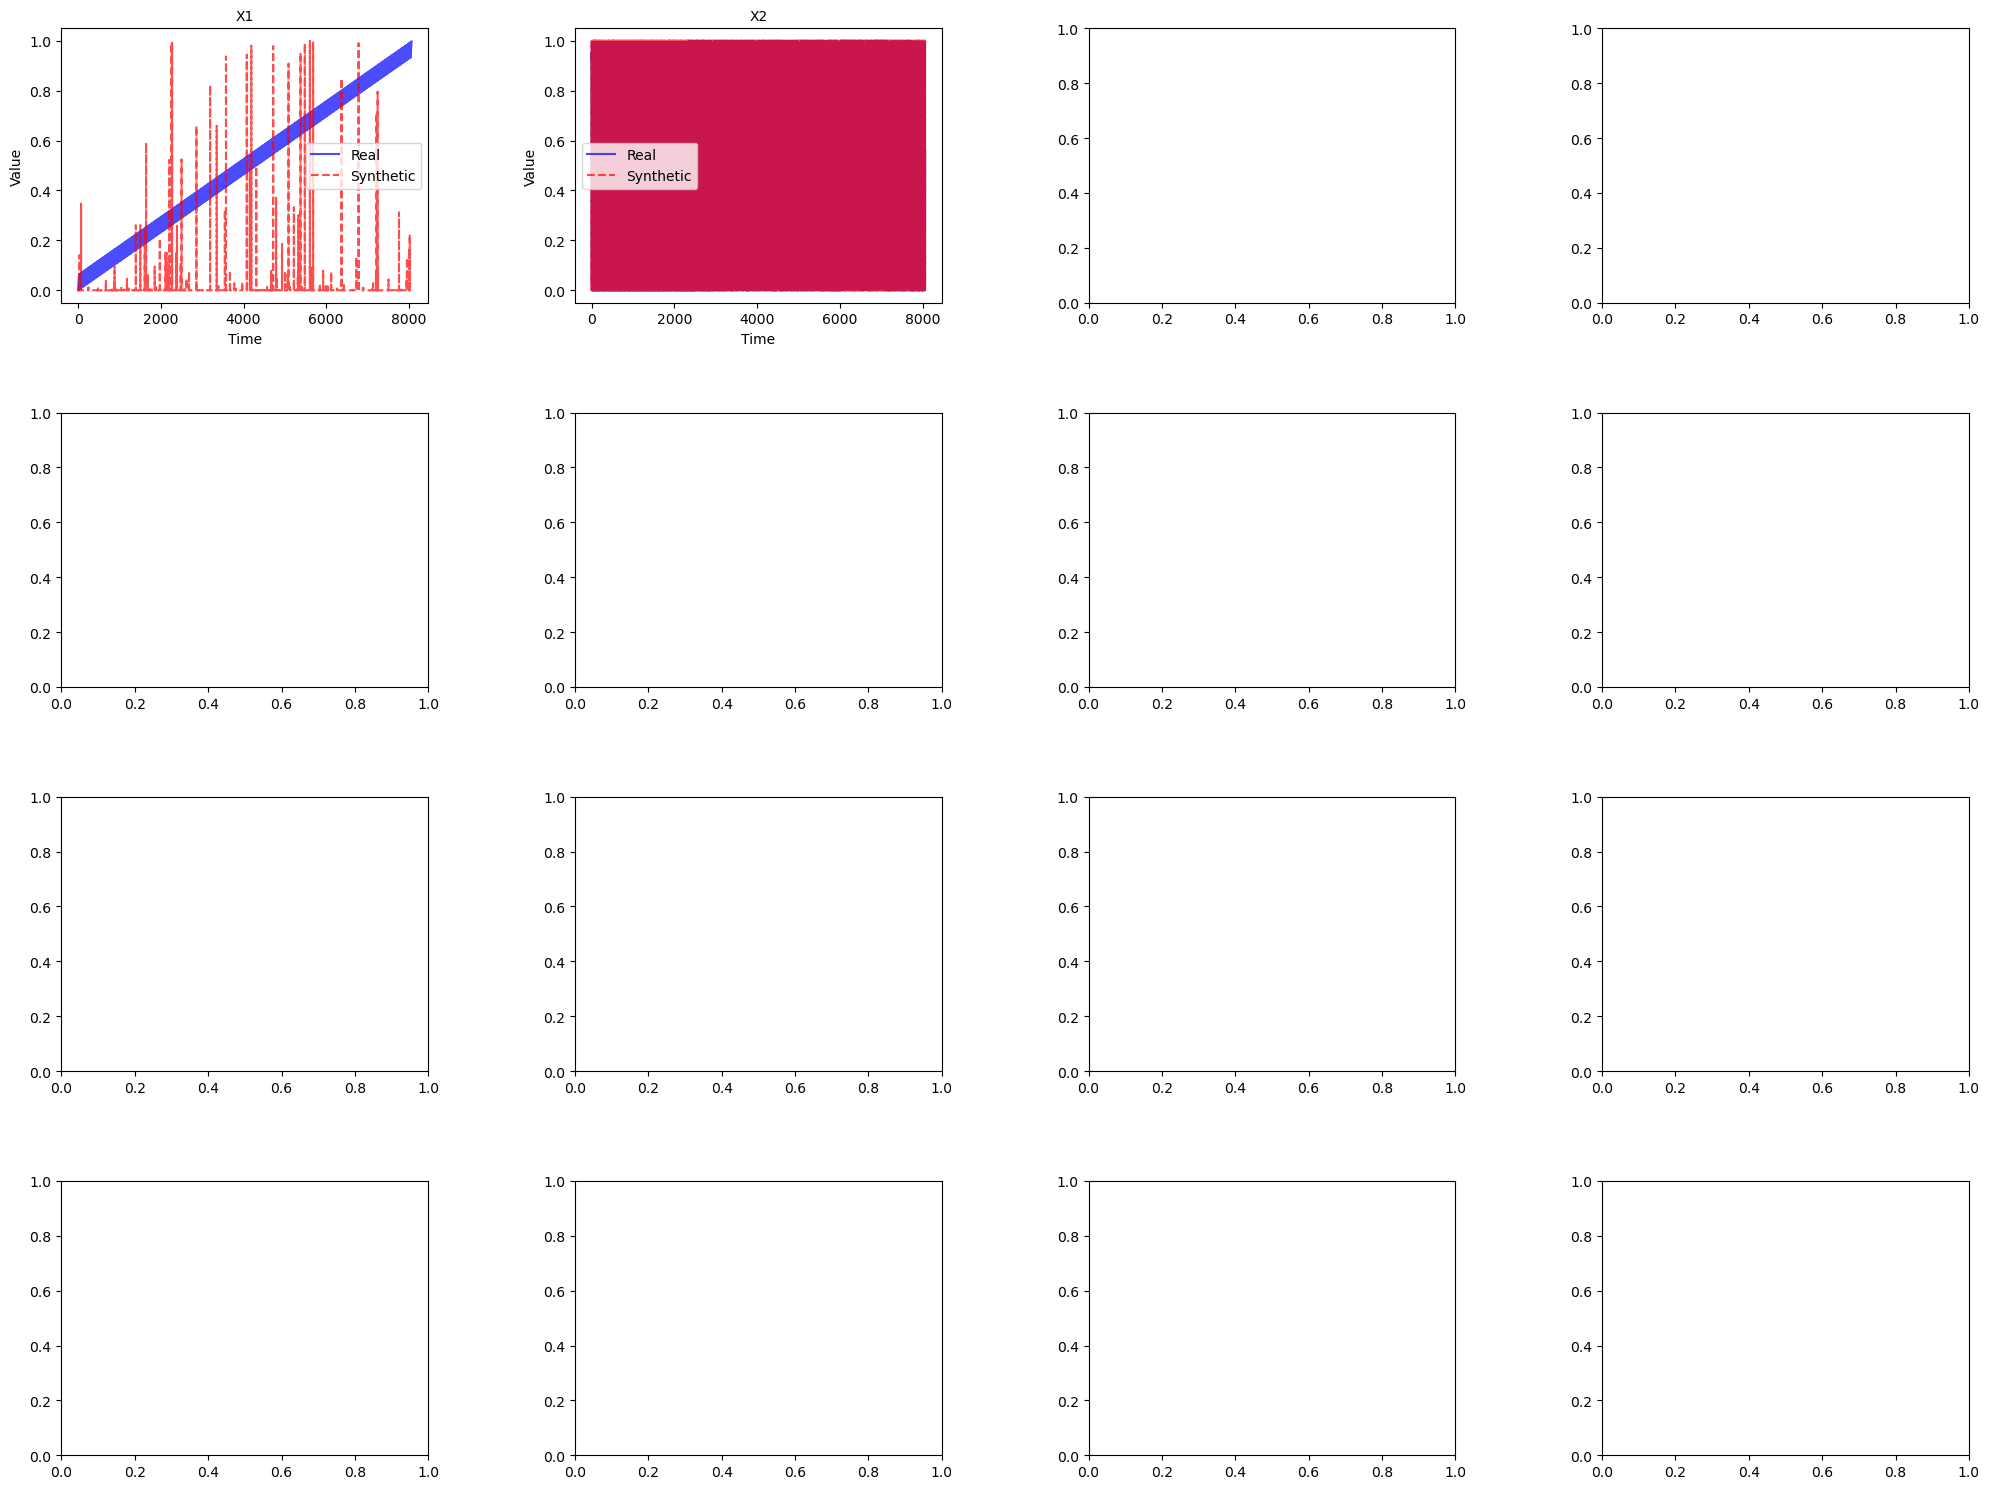

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Assume pd_reshaped and sd_reshaped are tensors with time-series data, 
# converted from the generated and real data respectively.
# Converting tensors to DataFrames for easier plotting
real_timeseries = pd.DataFrame(pd_reshaped.numpy(), columns=col_name)  # Real data
synth_timeseries = pd.DataFrame(sd_reshaped.numpy(), columns=col_name)  # Synthetic data

# Create a time index for plotting, assuming the data points are sequential
time_index = range(real_timeseries.shape[0])

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))  # Adjust layout as needed

for k in range(min(13, len(col_name))):  # Only plot as many subplots as there are columns
    ax = axes.flatten()[k]
    ax.plot(time_index, real_timeseries.iloc[:, k], color='blue', alpha=0.7, label='Real')
    ax.plot(time_index, synth_timeseries.iloc[:, k], color='red', alpha=0.7, linestyle='--', label='Synthetic')
    
    # Adding legends and titles
    ax.legend()
    ax.set_title(col_name[k], fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between plots
plt.savefig('hurricane_timeseries.png', dpi=300)  # Save figure
plt.show()
